In [32]:
import spacy
import pandas as pd
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt

In [17]:
nlp = spacy.load("en_core_web_md")

### Read dataset

In [18]:
df = pd.read_csv("tripadvisor_hoteles_cusco.csv")[:10]
df

,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped
0,Tocuyeros Boutique Hotel,PEN 677,julie w,Beautiful hotel,Lovely hotel in a great location. Just a short...,50,September 2023
1,Tocuyeros Boutique Hotel,PEN 677,steve w,great place and people,great place and people. we went from sept 16th...,50,September 2023
2,Tocuyeros Boutique Hotel,PEN 677,ShimonK2012,Excellent boutique hotel in prime location in ...,Our two night stay at Tocuyeros Boutique hotel...,50,September 2023
3,Tocuyeros Boutique Hotel,PEN 677,scott m,Amazing hotel!!,"Excellent accommodations, extremely friendly s...",50,August 2023
4,Tocuyeros Boutique Hotel,PEN 677,Genta M,Great time in Cusco,We had a great time in this hotel. It was clea...,50,August 2023
5,Tocuyeros Boutique Hotel,PEN 677,Mel M,"Great, personalized hotel experience in cute n...",This is a wonderful hotel in a perfect spot in...,50,August 2023
6,Tocuyeros Boutique Hotel,PEN 677,claudia,"Our stay in Cusco, Tocuyeros boutique hotel",The entrance to this hidden gem has a tunnel t...,50,June 2023
7,Tocuyeros Boutique Hotel,PEN 677,I P,A Cusco gem & family friendly,My wife and I stayed with our two young kids (...,50,July 2023
8,Tocuyeros Boutique Hotel,PEN 677,Xiomara L,Felt like home!,My family and I stayed at Tocuyeros Boutique H...,50,July 2023
9,Tocuyeros Boutique Hotel,PEN 677,Steven M,Perfect get away!,We had an amazing stay at the Tocuyeros Boutiq...,50,May 2023


In [19]:
text = "The young man, still a boy, is played by Jake Gyllenhaal, one of his first staring assignments, I think."
doc = nlp(text)

In [20]:
data = []
columns = ["text", "lemma", "pos", "tag", "dep", "shape", "is_alpha", "is_stop"]
for token in doc:
    data.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop])

df_doc = pd.DataFrame(data, columns=columns)
df_doc

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
0,The,the,DET,DT,det,Xxx,True,True
1,young,young,ADJ,JJ,amod,xxxx,True,False
2,man,man,NOUN,NN,nsubjpass,xxx,True,False
3,",",",",PUNCT,",",punct,",",False,False
4,still,still,ADV,RB,advmod,xxxx,True,True
5,a,a,DET,DT,det,x,True,True
6,boy,boy,NOUN,NN,appos,xxx,True,False
7,",",",",PUNCT,",",punct,",",False,False
8,is,be,AUX,VBZ,auxpass,xx,True,True
9,played,play,VERB,VBN,ccomp,xxxx,True,False


In [21]:
def get_entities(sent):
      ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [22]:
text_list = df["f5_contenido"][0].split(".")
print(text_list)

text = text_list[0]
# text = "the film had 200 patents"

print(text)
get_entities(text)

['Lovely hotel in a great location', ' Just a short walk from the main square', ' Staff were very welcoming and friendly', ' Room was comfortable', ' My breakfast was amazing, I can’t eat eggs so I had a wonderful breakfast of the most delicious fruit, oatmeal and then cheese meat and avocado', ' I don’t particularly like avocado in the UK but over in Peru it was delicious', ' I was able to leave my luggage until the evening as I had a late flight', '']
Lovely hotel in a great location


['', 'great  location']

In [23]:
entity_pairs = []

for k in range(len(df)):
    text_list = df["f5_contenido"][k].split(".")
    for text in text_list:
        entities = get_entities(text)
        entity_pairs.append(entities)

In [24]:
def get_relation(sent):
    
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [25]:
get_relation("John completed the task")

'completed'

In [26]:
entity_pairs = []
relations = []
data = []
for k in range(len(df)):
    text_list = df["f5_contenido"][k].split(".")
    for text in text_list:
        entities = get_entities(text)
        
        try:
            relation = get_relation(text)
            relations.append(relation)
            entity_pairs.append(entities)
        except:
            pass

In [27]:
pd.Series(relations).value_counts()[:50]

was                   7
is                    6
Thank                 5
Team                  5
recommend             5
were                  4
regards               3
let                   3
helped                2
be                    2
are committed         2
are glad              2
were able             2
stayed at             2
hope                  2
was clean             2
had                   2
has                   2
served                1
'm                    1
enjoy                 1
book                  1
was polite            1
appeared              1
have vintage          1
offered laundry       1
booked                1
Mrs                   1
know for sure         1
speak enough          1
travel                1
hotel in              1
thought of            1
appreciate            1
are                   1
was easy              1
say enough            1
checked on            1
is great              1
pack                  1
went on               1
brought         

In [28]:
entity_pairs

[['', 'great  location'],
 ['', 'main  square'],
 ['Staff', ''],
 ['Room', ''],
 ['so  I', 'delicious  fruit'],
 ['particularly  it', 'particularly  Peru'],
 ['I', 'late  flight'],
 ['', ''],
 ['we', 'sept 22nd'],
 ['weather', ''],
 ['very  we', 'help'],
 ['breakfast', 'cheap tea US'],
 ['we', 'good  price'],
 ['just cusco plumbing', ''],
 ['you', 'toilet toilet'],
 ['us', ''],
 ['', 'early  morning'],
 ['', ''],
 ['only  us', 'Tripadvisor recommendation'],
 ['We', 'so  us'],
 ['you', 'soon  Cusco'],
 ['', ''],
 ['stay', 'Tocuyeros Boutique hotel'],
 ['bedroom', 'size'],
 ['very dining our', 'start  hiking'],
 ['', ''],
 ['we', 'away  home'],
 ['we', 'right  track'],
 ['kind  We', 'you'],
 ['how  location', ''],
 ['', ''],
 ['', 'Stellar art kids'],
 ['I', 'again  visitors'],
 ['Dear  scottmA4607GQ', 'amazing  comment'],
 ['you', 'us'],
 ['wonderful  you', 'time'],
 ['you', ''],
 ['', ''],
 ['We', 'great  hotel'],
 ['very  breakfast', ''],
 ['greatly  flight', 'afternoon'],
 ['I', 'hig

In [29]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]
print(len(source), len(target), len(relations))
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

114 114 114


,source,target,edge
0,,great location,hotel in
1,,main square,walk from
2,Staff,,were
3,Room,,was comfortable
4,so I,delicious fruit,eat
...,...,...,...
109,,amazing comment,Thank
110,you,us,are glad
111,wonderful you,time,is
112,you,,hope


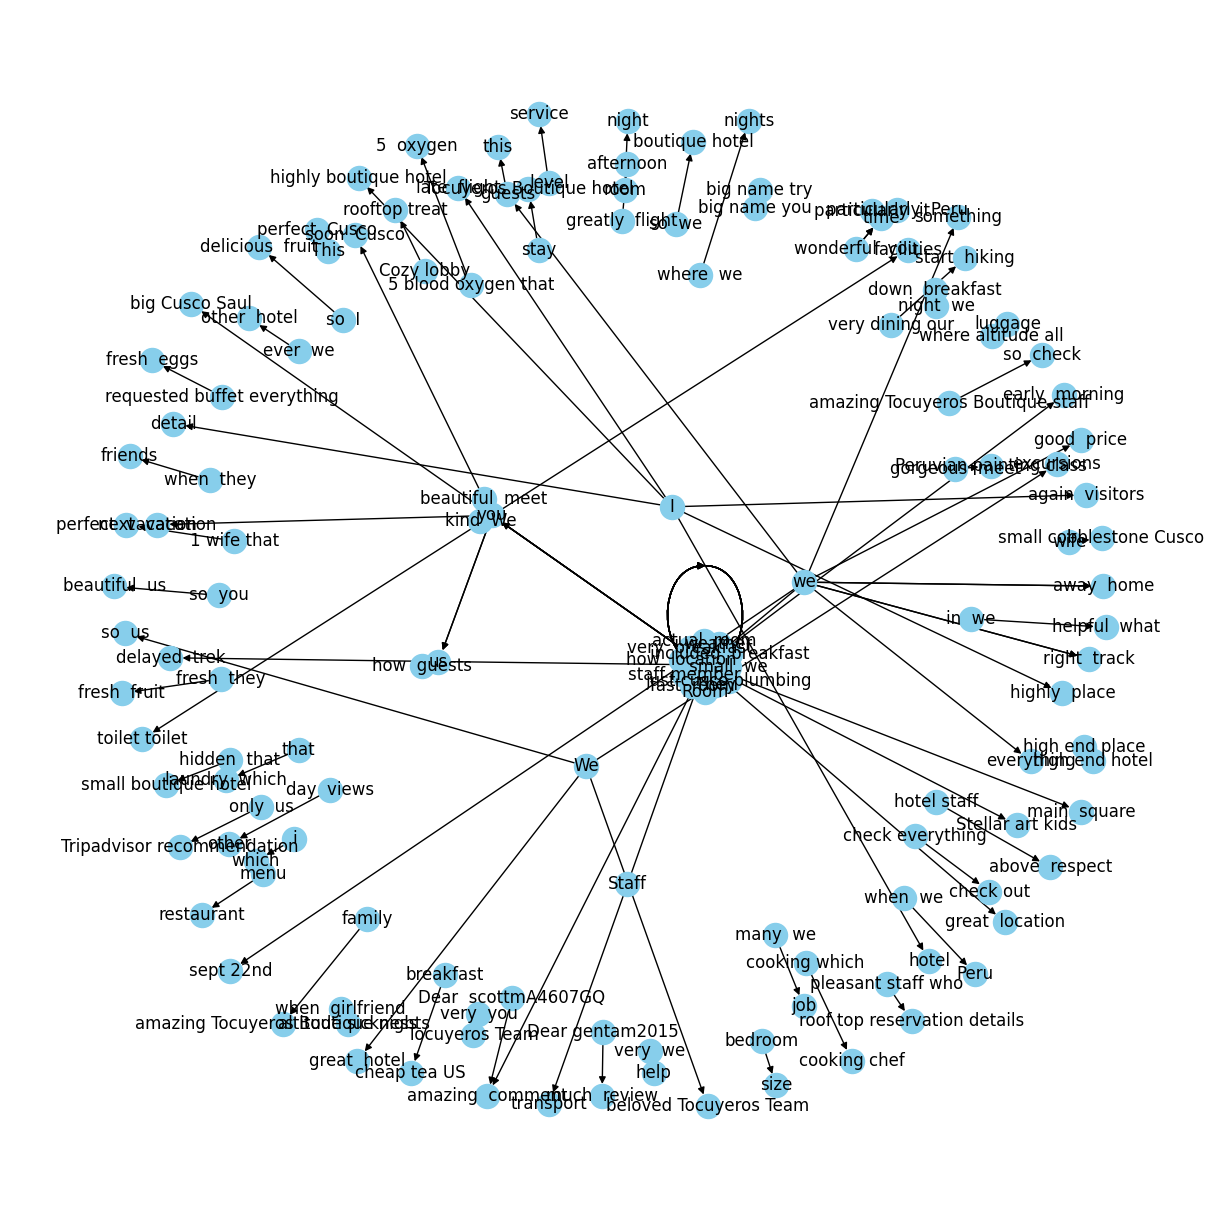

In [33]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [36]:
text = df["f5_contenido"][0]

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

In [26]:
import spacy
from spacy.matcher import Matcher

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Create a Matcher object
matcher = Matcher(nlp.vocab)

# Define a pattern for matching: Here, we are looking for the phrase "example of"
pattern = [{"LOWER": "example"}, {"LOWER": "of"}]

# Add the pattern to the matcher with a unique name and the defined pattern
matcher.add("example_pattern", [pattern])

# Text to be processed
text = "This is an example of SpaCy Matcher in action."

# Process the text with SpaCy
doc = nlp(text)

# Use the matcher on the processed text
matches = matcher(doc)

# Iterate over the matches and print the matched span
for match_id, start, end in matches:
    matched_span = doc[start:end]
    print(f"Match found: '{matched_span.text}' (start: {start}, end: {end})")


Match found: 'example of' (start: 3, end: 5)
